### Darts predictions for JNJ stock prices
- prepare data for use with Darts library
- data analysis
- model evaluation (percent error for models)
- historical forecasting


In [103]:
import pandas as pd
from darts import TimeSeries
df = pd.read_csv("/home/becode/Desktop/Time Series/venv/scr/data/yfin_JNJ.csv", delimiter=",", index_col='Date', parse_dates = ['Date'] )
df = df[(df.index < '01-12-2020')]

In [104]:
print(type(df.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [105]:
df.index= pd.to_datetime(df.index , unit='D')
df.index

DatetimeIndex(['2005-01-03', '2005-01-04', '2005-01-05', '2005-01-06',
               '2005-01-07', '2005-01-10', '2005-01-11', '2005-01-12',
               '2005-01-13', '2005-01-14',
               ...
               '2019-12-27', '2019-12-30', '2019-12-31', '2020-01-02',
               '2020-01-03', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10'],
              dtype='datetime64[ns]', name='Date', length=3782, freq=None)

In [106]:
ser = df['Close']
r = ser.resample("W").sum()
r.index


DatetimeIndex(['2005-01-09', '2005-01-16', '2005-01-23', '2005-01-30',
               '2005-02-06', '2005-02-13', '2005-02-20', '2005-02-27',
               '2005-03-06', '2005-03-13',
               ...
               '2019-11-10', '2019-11-17', '2019-11-24', '2019-12-01',
               '2019-12-08', '2019-12-15', '2019-12-22', '2019-12-29',
               '2020-01-05', '2020-01-12'],
              dtype='datetime64[ns]', name='Date', length=784, freq='W-SUN')

Use TimeSeries.from_series to convert data to be used with Darts library

In [107]:
ser = df['Close']
series = TimeSeries.from_series(r, fill_missing_dates=True, freq=None)

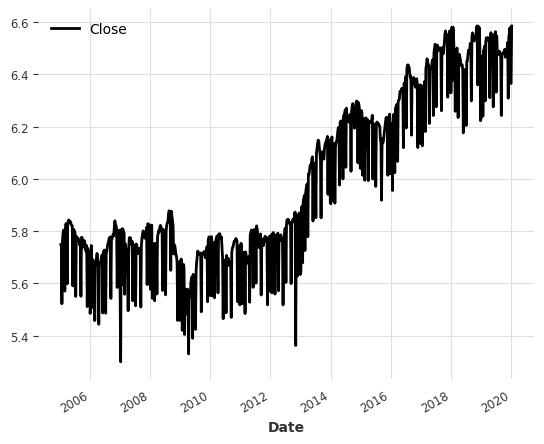

In [108]:
import numpy as np
series.map(np.log).plot()

12 periods to shift for calculating difference

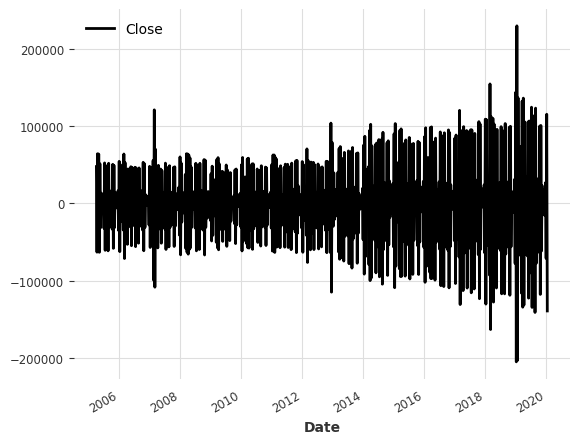

In [109]:
series.diff(12).plot()

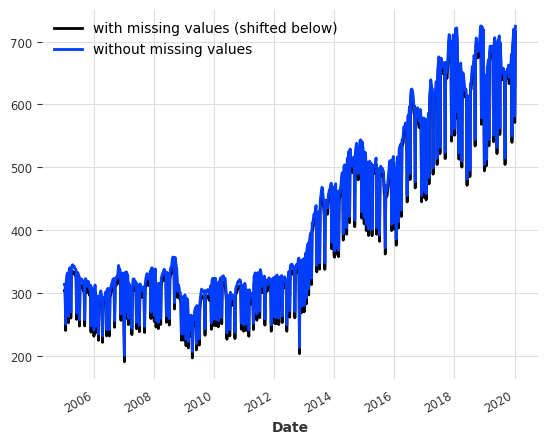

In [110]:
from darts.utils.missing_values import fill_missing_values

(series - 10).plot(label="with missing values (shifted below)")
fill_missing_values(series).plot(label="without missing values")

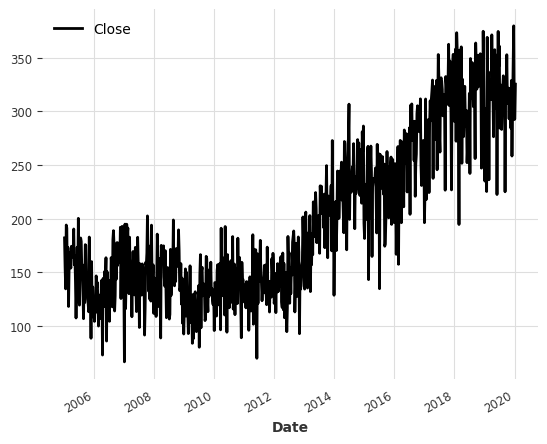

In [111]:
import numpy as np
series_noise = TimeSeries.from_times_and_values(
    series.time_index, np.random.randn(len(series))
)
(series / 2 + 20 * series_noise - 10).plot()



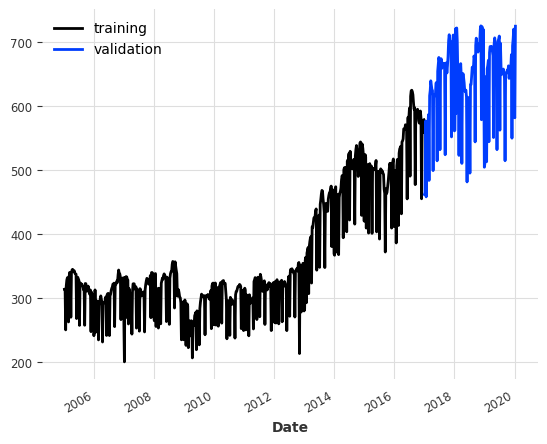

In [122]:
train, val = series.split_before(pd.Timestamp("20170101"))
train.plot(label="training")
val.plot(label="validation")

NaiveSeasonal to predict future values

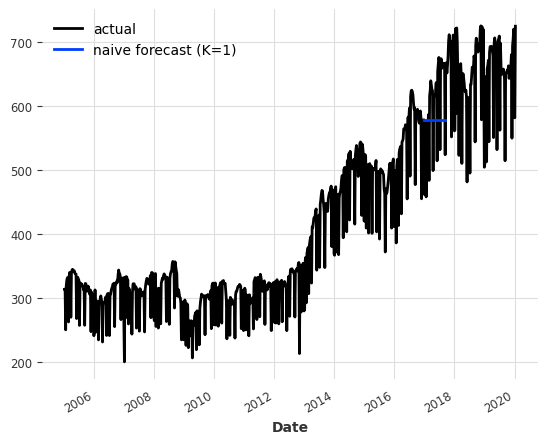

In [123]:
from darts.models import NaiveSeasonal

naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive forecast (K=1)")

Use Darts check_seasonality, check if data has a yearly seasonality, use auto-correlation function (ACF), and highlighting the lag m=12

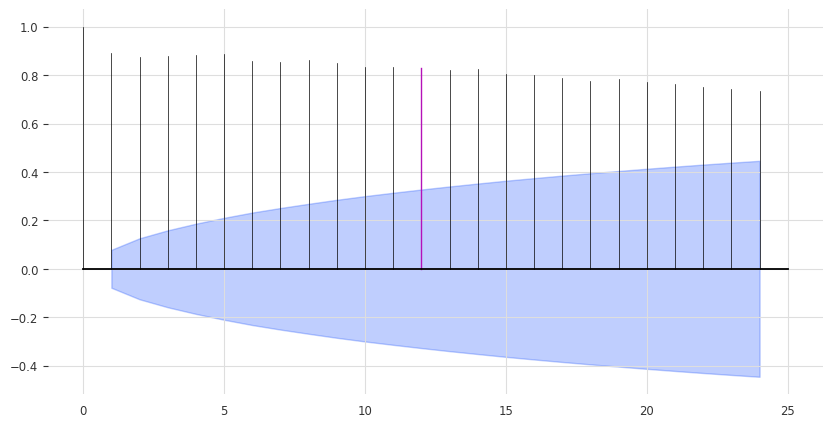

In [124]:
from darts.utils.statistics import plot_acf, check_seasonality
plot_acf(train, m=12, alpha=0.05)

In [125]:
for m in range(2, 25):
    is_seasonal, period = check_seasonality(train, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))

There is seasonality of order 5.
There is seasonality of order 8.
There is seasonality of order 11.
There is seasonality of order 14.
There is seasonality of order 19.


NaiveSeasonal model again with a seasonality of 8:

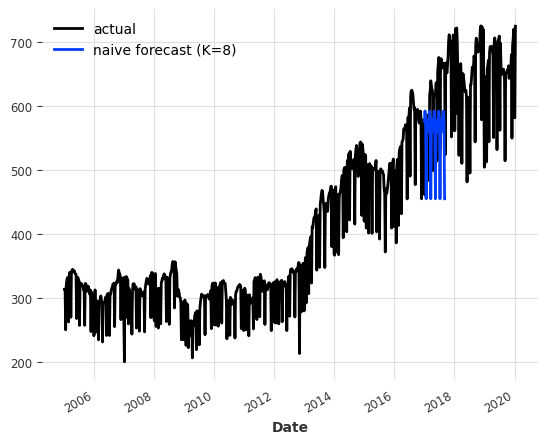

In [126]:
seasonal_model = NaiveSeasonal(K=8)
seasonal_model.fit(train)
#Forecasts values for n time steps after the end of the training series.
seasonal_forecast = seasonal_model.predict(36)
series.plot(label="actual")
seasonal_forecast.plot(label="naive forecast (K=8)")

Predict for 36 steps (1 month ) in the future - number of time steps (after the end of the training series) over which to forecast<br>
Display the max value for the forecast

drift_forecast <TimeSeries (DataArray) (Date: 1, component: 1, sample: 1)>
array([[[593.65999919]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2017-01-01
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
combined_forecast <TimeSeries (DataArray) (Date: 1, component: 1, sample: 1)>
array([[[606.45167288]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2017-01-01
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None


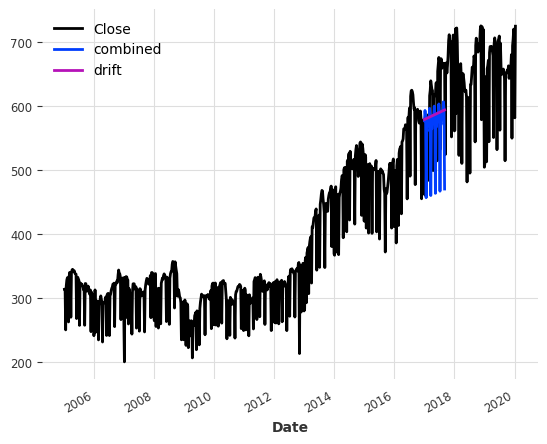

In [127]:
from darts.models import NaiveDrift

drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)
print('drift_forecast' , drift_forecast.max(axis=0))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
print('combined_forecast' , combined_forecast.max(axis=0))
series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")

Check if there is correlation between holidays and stock prices

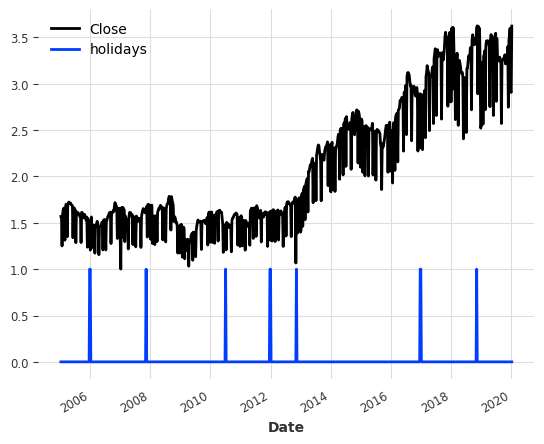

In [128]:
(series / 200).add_holidays("US").plot()

Display the percentage error when evaluating prediction results

In [129]:
from darts.metrics import mape
print(
    "Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(
        mape(series, combined_forecast)
    )
)

Mean absolute percentage error for the combined naive drift + seasonal: 11.02%.


### Evaluate the percentage error for different models with JNJ dataset

In [130]:
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta

def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, mape(val, forecast)))


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

model ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=52 obtains MAPE: 8.16%
model (T)BATS obtains MAPE: 8.66%
model Auto-ARIMA obtains MAPE: 10.55%
model Theta(2) obtains MAPE: 11.68%


hyper-parameters with the Theta method<br>
## Backtesting: simulate historical forecasting

In [131]:
# Search for the best theta parameter, by trying 50 different values
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta
best_theta_model = Theta(best_theta)
best_theta_model.fit(train)
pred_best_theta = best_theta_model.predict(len(val))

print(
    "The MAPE is: {:.2f}, with theta = {}.".format(
        mape(val, pred_best_theta), best_theta
    )
)

The MAPE is: 8.54, with theta = -1.0612244897959187.


  0%|          | 0/313 [00:00<?, ?it/s]

MAPE = 6.93%


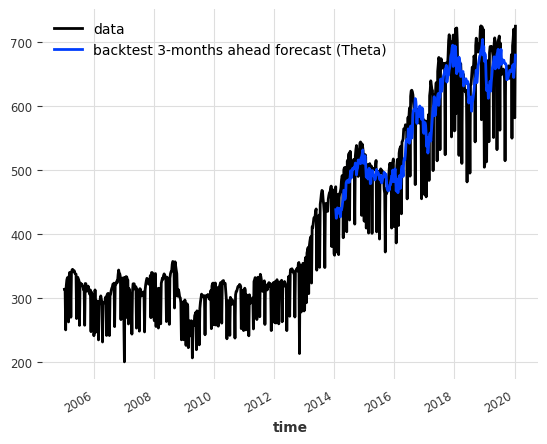

In [132]:
historical_fcast_theta = best_theta_model.historical_forecasts(
    series, start=0.6, forecast_horizon=3, verbose=True
)

series.plot(label="data")
historical_fcast_theta.plot(label="backtest 3-months ahead forecast (Theta)")
print("MAPE = {:.2f}%".format(mape(historical_fcast_theta, series)))

In [133]:
average_error = best_theta_model.backtest(
    series,
    start=0.6,
    forecast_horizon=3,
    metric=mape,
    reduction=np.mean,  # this is actually the default
    verbose=True,
)

print("Average error (MAPE) over all historical forecasts: %.2f" % average_error)

  0%|          | 0/313 [00:00<?, ?it/s]

Average error (MAPE) over all historical forecasts: 7.39


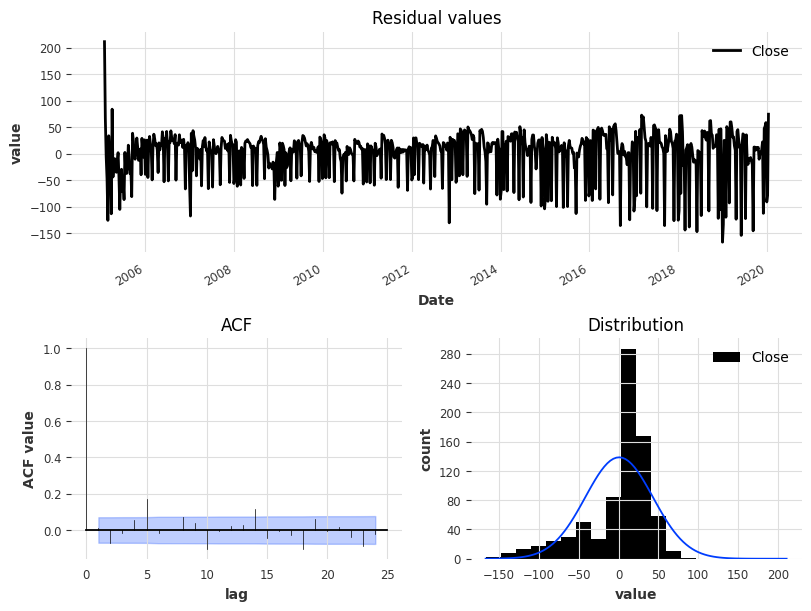

In [134]:
from darts.utils.statistics import plot_residuals_analysis

plot_residuals_analysis(best_theta_model.residuals(series))